In [1]:
from itertools import chain

from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A

from itertools import chain

import textdistance

import pprint

import matplotlib.pyplot as plt

import textwrap
import random

In [2]:
adapter_string = "sqlite:obo:envo"

In [3]:
target_labels = ["soil"]

In [4]:
exclusion_labels = ["enriched soil"]

In [5]:
adapter = get_adapter(adapter_string)

In [6]:
targets = set()

In [7]:
# accumulate subclasses of the target classes (by label)
# 
for current_label in target_labels:
    # print(tc)
    for class_id in adapter.basic_search(current_label):
        # print(class_id)
        descendant = adapter.descendants(class_id, predicates=[IS_A])
        for d in descendant:
            targets.add(d)
            
print(len(targets))

130


In [8]:
# deplete subclasses of the exclusion classes (by label)
# 
for current_label in exclusion_labels:
    for class_id in adapter.basic_search(current_label):
        descendant = adapter.descendants(class_id, predicates=[IS_A])
        for d in descendant:
            targets.remove(d)

print(len(targets))

97


In [9]:
up_rels = adapter.relationships(targets)


In [10]:
down_rels = adapter.relationships(objects = targets)


In [11]:
rels_gen = chain(up_rels, down_rels)

In [12]:
rels_list = []

In [13]:
preds_count = {}

In [14]:
for rel in rels_gen:
    s, p, o = rel
    inner_dict = {
        "s": s,
        "slab": adapter.label(s),
        "p": p,
        "plab": adapter.label(p),
        "p_lab_or_id": adapter.label(p) if adapter.label(p) is not None else p,
        "o": o,
        "olab": adapter.label(o),
        "slab_olab_cosine": textdistance.cosine(adapter.label(s), adapter.label(o))
    }

    if inner_dict['p_lab_or_id'] in preds_count:
        preds_count[inner_dict['p_lab_or_id']] += 1
    else:
        preds_count[inner_dict['p_lab_or_id']] = 1

    rels_list.append(inner_dict)


In [15]:
pprint.pprint(dict(sorted(preds_count.items())))

{'adjacent to': 2,
 'characteristic of': 12,
 'composed primarily of': 8,
 'derives from': 2,
 'determined by': 1,
 'formed as result of': 2,
 'has characteristic': 1,
 'has disposition': 1,
 'has increased levels of': 1,
 'has output': 1,
 'has part': 10,
 'has participant': 3,
 'has quality': 7,
 'located in': 9,
 'occurs in': 4,
 'output of': 3,
 'part of': 18,
 'partially_surrounded_by': 1,
 'rdfs:subClassOf': 212}


In [16]:
sorted_by_count = sorted(preds_count.items(), key=lambda item: (-item[1], item[0]))

pprint.pprint(sorted_by_count)


[('rdfs:subClassOf', 212),
 ('part of', 18),
 ('characteristic of', 12),
 ('has part', 10),
 ('located in', 9),
 ('composed primarily of', 8),
 ('has quality', 7),
 ('occurs in', 4),
 ('has participant', 3),
 ('output of', 3),
 ('adjacent to', 2),
 ('derives from', 2),
 ('formed as result of', 2),
 ('determined by', 1),
 ('has characteristic', 1),
 ('has disposition', 1),
 ('has increased levels of', 1),
 ('has output', 1),
 ('partially_surrounded_by', 1)]


In [17]:
# pprint.pprint(rels_list)

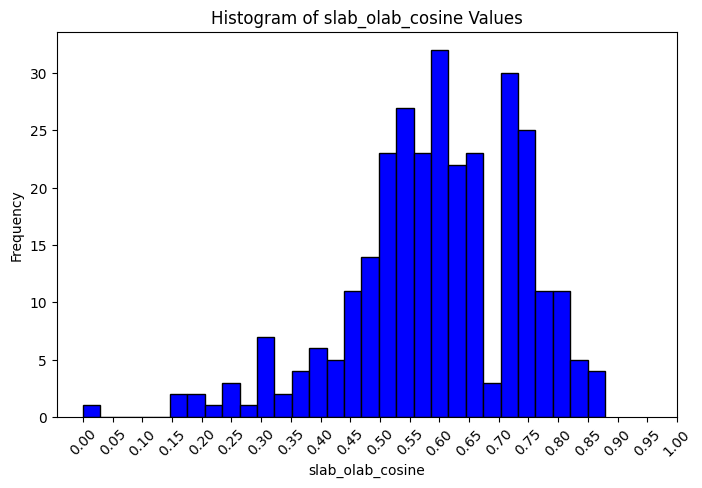

In [18]:
# Extract the 'slab_olab_cosine' values
cosine_values = [item['slab_olab_cosine'] for item in rels_list]

# Plot histogram with increased bins
plt.figure(figsize=(8, 5))
plt.hist(cosine_values, bins=30, color='blue', edgecolor='black')

# Set x-axis ticks at every 0.1 interval
plt.xticks([x / 20 for x in range(0, 21)], rotation=45)

plt.title("Histogram of slab_olab_cosine Values")
plt.xlabel("slab_olab_cosine")
plt.ylabel("Frequency")
plt.show()

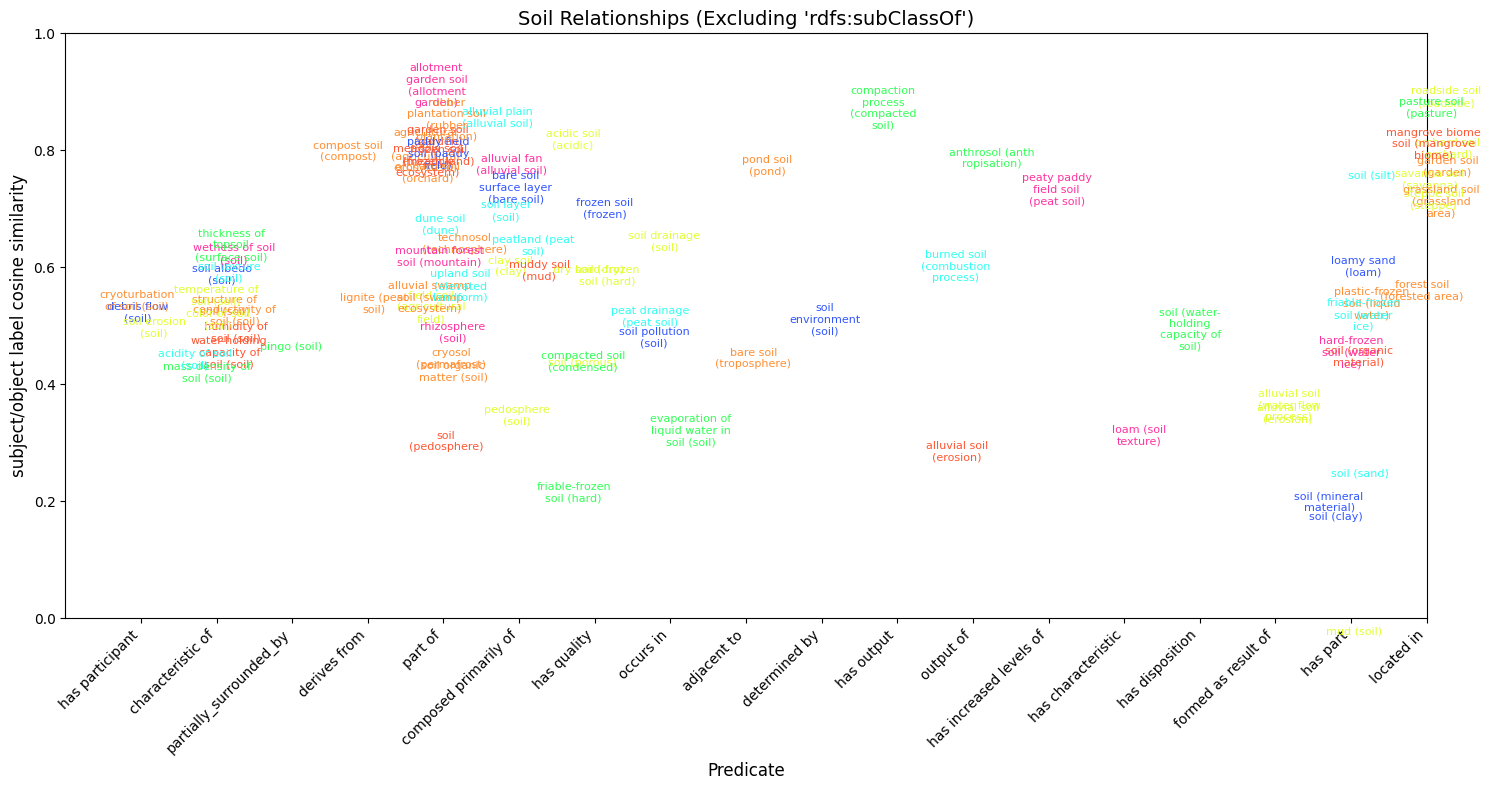

In [19]:
# Filter out items where 'p_lab_or_id' is 'rdfs:subClassOf'
filtered_data = [item for item in rels_list if item['p_lab_or_id'] != 'rdfs:subClassOf']

# Extract unique groups from 'p_lab_or_id' and map each one to an x-axis position
groups = {item['p_lab_or_id'] for item in filtered_data}
group_positions = {group: idx + 1 for idx, group in
                   enumerate(groups)}  # Assign positions for each unique 'p_lab_or_id' group


# Helper function to wrap labels
def wrap_label(label, width=15):
    return "\n".join(textwrap.wrap(label, width))


# Define a set of colors to choose from (optional)
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#FF8F33', '#33FFF2', '#E1FF33']

# Adjust the figure size and font size
plt.figure(figsize=(15, 8))

# Plot each label with more random jitter and random color
for item in filtered_data:
    x = group_positions[item['p_lab_or_id']]
    y = item['slab_olab_cosine']
    label = f"{item['slab']} ({item['olab']})"
    wrapped_label = wrap_label(label, width=15)  # Wrap the label to 15 characters per line

    # Add increased random jitter to the label position
    x_jitter = random.uniform(-0.3, 0.3)  # Larger random jitter in x-axis
    y_jitter = random.uniform(-0.1, 0.1)  # Larger random jitter in y-axis

    # Select a random color for the label
    color = random.choice(colors)  # Alternatively, use color = (random.random(), random.random(), random.random())

    # Plot the label with random color
    plt.text(x + x_jitter, y + y_jitter, wrapped_label, ha='center', va='bottom', fontsize=8, color=color)

# Increase x-tick label size and rotate
plt.xticks(ticks=list(group_positions.values()), labels=list(group_positions.keys()), rotation=45, ha='right',
           fontsize=10)

# Configure other plot aesthetics
plt.xlabel("Predicate", fontsize=12)
plt.ylabel("subject/object label cosine similarity", fontsize=12)
plt.title("Soil Relationships (Excluding 'rdfs:subClassOf')", fontsize=14)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()